In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn

In [2]:
%matplotlib inline

In [3]:
ask = pd.read_csv("datasets/spread_15m_EUR/ask.csv", parse_dates=["date"])
ask["change_close"] = (ask["close"] - ask["close"].shift(1))
ask["change_volume"] = (ask["volume"] - ask["volume"].shift(1))
ask.drop(["high", "low", "open"], axis=1, inplace=True)

bid = pd.read_csv("datasets/spread_15m_EUR/bid.csv", parse_dates=["date"])
bid["change_close"] = (bid["close"] - bid["close"].shift(1))
bid["change_volume"] = (bid["volume"] - bid["volume"].shift(1))
bid.drop(["high", "low", "open"], axis=1, inplace=True)

In [25]:
df = pd.merge(ask, bid, on='date', how="inner", suffixes=("_ask", "_bid"))
df["date"] = pd.to_datetime(df["date"], dayfirst=True, utc=True)

df["spread"] = df["close_ask"] - df["close_bid"]
df["mean_change_close"] = (df["change_close_ask"] + df["change_close_bid"]) / 2
df["mean_change_volume"] = (df["change_volume_ask"] + df["change_volume_bid"]) / 2
df["hour"] = df["date"].dt.hour

df = df.dropna()

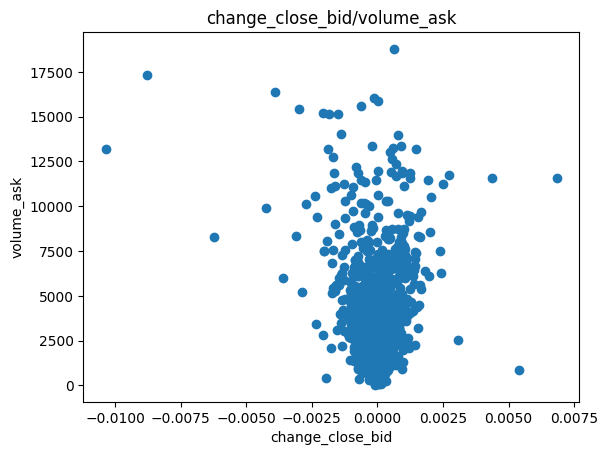

In [35]:
x_axis = "change_close_bid"
y_axis = "volume_ask"

plt.scatter(df[x_axis], df[y_axis])
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.title(f"{x_axis}/{y_axis}")
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['spread'], df['mean_change_close'], df['mean_change_volume'])
ax.set_xlabel('spread')
ax.set_ylabel('mean change close')
ax.set_zlabel('mean change volume')
plt.show()

Model Code

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, n_layers: int, classification: bool = False):
        super(MLP, self).__init__()
        
        assert input_size > 0
        assert hidden_size > 0
        assert output_size > 0
        assert hidden_size > 0
        assert (classification and output_size > 1) or not classification
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            *[
                nn.ReLU() if i % 2 == 0 else nn.Linear(hidden_size, hidden_size) for i in range(n_layers*2)
            ],
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
        self.last_layer = nn.Softmax(dim=1) if classification else nn.Identity()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.last_layer(self.layers(x))

In [57]:
lable = df["mean_change_close"].astype(np.float32).to_numpy().reshape(-1, 1)
features = df.drop(["date", "change_close_ask", "change_close_bid", "mean_change_close"], axis=1).astype(np.float32).to_numpy()
lable = torch.from_numpy(lable).to(device=device).type(torch.float32)
features = torch.from_numpy(features).to(device=device).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(features, lable, test_size=0.2)

In [58]:
model = MLP(
    input_size=features.shape[1],
    hidden_size=100,
    output_size=y_train.shape[1],
    n_layers=4,
    classification=False
).to(device=device)
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10000

In [59]:
model.train()
for epoch in range(epochs):
    y_pred = model(X_train)
    optimiser.zero_grad()
    loss = criterion(y_pred, y_train)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimiser.step()
    
    if epoch % 100 == 0:
        model.eval()
        with torch.inference_mode():
            y_pred = model(X_test)
        loss = criterion(y_pred, y_test)
        print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 50.0989990234375
Epoch: 100 | Loss: 0.06970854103565216
Epoch: 200 | Loss: 0.0017748831305652857
Epoch: 300 | Loss: 0.00011671621905406937
Epoch: 400 | Loss: 0.00011740622721845284
Epoch: 500 | Loss: 0.0001111296660383232
Epoch: 600 | Loss: 0.00010889280383707955
Epoch: 700 | Loss: 0.00011152136721648276
Epoch: 800 | Loss: 0.00012157165474491194
Epoch: 900 | Loss: 0.00016224342107307166
Epoch: 1000 | Loss: 0.00015539278683718294
Epoch: 1100 | Loss: 0.0001667399483267218
Epoch: 1200 | Loss: 0.00016176833014469594
Epoch: 1300 | Loss: 0.0001714917889330536
Epoch: 1400 | Loss: 0.00018020157585851848
Epoch: 1500 | Loss: 0.00017837293853517622
Epoch: 1600 | Loss: 0.00017105751612689346
Epoch: 1700 | Loss: 0.00017010692681651562
Epoch: 1800 | Loss: 0.00017188732454087585
Epoch: 1900 | Loss: 0.00016633584164083004
Epoch: 2000 | Loss: 0.0001811449765227735
Epoch: 2100 | Loss: 0.00017045617278199643
Epoch: 2200 | Loss: 0.00017108746396843344
Epoch: 2300 | Loss: 0.000188126388820

KeyboardInterrupt: 